In [1]:
import numpy as np
import statsmodels.api as sm
import pystan

from scipy.stats import norm

## Modelos Bayesianos con errores asociados a la medición

Normalmente la metodología para realizar modelos de regresiones asumen datos si errores de medición asociados, o que la varianza no se conoce del todo. Cuando el error de la medición es más grande en comparación con la cantidad que se está midiendo es importante introducir este error en las variables y tomarlo en cuenta en el modelo.

En el siguiente ejemplo se asume  un modelo lineal en donde los valores verdaderos del predictor Xi, y la respuesta Yi no son conocidos, sino únicamente las variables observadas. 

Si las incertidumbres de error de la medición se pueden estimar, los valores observados se pueden modelar en función de los valores reales más un ruido de medición, que es lo que precisamente se quiere demostrar en este notebook. Generalmente se utilizar un error normal con una desviación conocida.

In [2]:
#Datos creados sintéticamente

np.random.seed(1056) 
nobs = 1000
sdobsx = 1.25
truex = norm.rvs(0,2.5, size=nobs) #variable normal
errx = norm.rvs(0, sdobsx, size=nobs) #errores
obsx = truex + errx

beta0 = -4
beta1 = 7
sdy = 1.25
sdobsy = 2.5

erry = norm.rvs(0, sdobsy, size=nobs)
truey = norm.rvs(beta0 + beta1*truex, sdy, size=nobs)
obsy = erry + truey

In [3]:
#Fit

toy_data = {} #Diccionario
toy_data['N'] = nobs #Tamaño de la muestra
toy_data['obsx'] = obsx #Variable explicatoria
toy_data['errx'] = errx #Error asociado a la variable
toy_data['obsy'] = obsy #Variable de resupuesta
toy_data['erry'] = erry #Error asociado a esta variable de respuesta
toy_data['xmean'] = np.repeat(0, nobs) #Media de la variable de entrada


## Prueba del modelo sin error incluido

In [10]:
# Stan code
stan_code_noError = """
data{
    int<lower=0> N;
    vector[N] obsx;
    vector[N] obsy;
    vector[N] errx;
    vector[N] erry;
    vector[N] xmean;
}
transformed data{
    vector[N] varx;
    vector[N] vary;
    
    for(i in 1:N){
        varx[i] = fabs(errx[i]);
        vary[i] = fabs(erry[i]);
    }
}
parameters{
    real beta0;
    real beta1;
    real<lower=0> sigma;
    vector[N] x;
    vector[N] y;
}
transformed parameters{
    vector[N] mu;
    
    for (i in 1:N){
        mu[i] = beta0 + beta1 * x[i];
    }
}
model{
    beta0 ~ normal(0.0,100); #diffuse normal priors for predictors
    beta1 ~ normal(0.0,100); 
    
    sigma ~ uniform(0.0,100); #uniform prior for standard deviation
    
    x ~ normal(xmean, 100);
    obsx ~ normal(x, sigma);
    y ~ normal(mu, sigma);
    obsy ~ normal(y, sigma);
}
"""

In [11]:
#Run mcm
fit = pystan.stan(model_code=stan_code_noError, data=toy_data, iter=5000, chains=3, n_jobs=3, warmup=2500, verbose=False, thin=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a76ea281a5ac3a6bd49df36dd8320168 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
#Salida
nlines = 8

output = str(fit).split('\n')
for item in output[:nlines]:
    print(item)

Inference for Stan model: anon_model_a76ea281a5ac3a6bd49df36dd8320168.
3 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=7500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0     -3.26  3.6e-3   0.26  -3.78  -3.44  -3.26  -3.09  -2.74   5306    1.0
beta1      5.63  2.6e-3   0.09   5.44   5.57   5.63   5.69   5.81   1284    1.0
sigma      1.44  1.4e-3   0.04   1.37   1.41   1.44   1.46   1.52    795   1.01


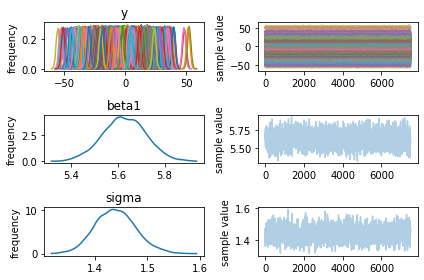

In [13]:
import pylab as plt

#Plot posterior and chain
fit.plot(['y','beta1','sigma'])
plt.tight_layout()
plt.show()

## Prueba del modelo con el error incluido

In [4]:
# Stan code
stan_code = """
data{
    int<lower=0> N;
    vector[N] obsx;
    vector[N] obsy;
    vector[N] errx;
    vector[N] erry;
    vector[N] xmean;
}
transformed data{
    vector[N] varx;
    vector[N] vary;
    
    for(i in 1:N){
        varx[i] = fabs(errx[i]);
        vary[i] = fabs(erry[i]);
    }
}
parameters{
    real beta0;
    real beta1;
    real<lower=0> sigma;
    vector[N] x;
    vector[N] y;
}
transformed parameters{
    vector[N] mu;
    
    for (i in 1:N){
        mu[i] = beta0 + beta1 * x[i];
    }
}
model{
    beta0 ~ normal(0.0,100); #diffuse normal priors for predictors
    beta1 ~ normal(0.0,100); 
    
    sigma ~ uniform(0.0,100); #uniform prior for standard deviation
    
    x ~ normal(xmean, 100);
    obsx ~ normal(x, varx);
    y ~ normal(mu, sigma);
    obsy ~ normal(y, vary);
}
"""

In [5]:
#Run mcm
fit = pystan.stan(model_code=stan_code, data=toy_data, iter=5000, chains=3, n_jobs=3, warmup=2500, verbose=False, thin=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_75fbdc3dab4628834fb23c0a17efda5e NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
#Salida
nlines = 8

output = str(fit).split('\n')
for item in output[:nlines]:
    print(item)

Inference for Stan model: anon_model_75fbdc3dab4628834fb23c0a17efda5e.
3 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=7500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0     -3.73  2.5e-3   0.15  -4.02  -3.83  -3.73  -3.63  -3.45   3517    1.0
beta1      6.68  1.8e-3   0.06   6.56   6.64   6.68   6.72    6.8   1057    1.0
sigma      1.68    0.01   0.18   1.35   1.55   1.68    1.8   2.07    215   1.02


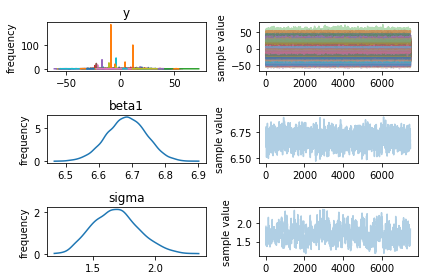

In [7]:
import pylab as plt

#Plot posterior and chain
fit.plot(['y','beta1','sigma'])
plt.tight_layout()
plt.show()

## Una forma de saber si el modelo convergio o no es ver la variable Rhat, si esta es 1 o cercano a 1 quiere decir que convergio

### A continuación se muestra una tabla donde se muestran las ventajas de utilizar un error asociado a la variable de estudio. Se observa como se reduce el error en mas de la mitada para ambas variables que se querian predecir (Beta0 y Beta1) 



| Modelo                          | Beta0       | Beta1         | %Error Beta0  | %Error Beta1  |
| :---                            |    :----:   |          ---: |          ---: |          ---: |
| Base                            | -4          | 7             | -             | -             |
|Modelo sin Considerar el Error   |  -3.26      | 5.63          | 18.5%         | 19.57%        |
|Modelo Considerando el Error     | -3.73       | 6.67          | 6.75%         | 4.71%         |               